# 수입 화물 우범도 예측 모델 개발

## 참고사항 0)
관세청에서 수입품의 정보를 보고 **우범(불법)인지 아닌지를 예측하는 문제**입니다. 1-12월 데이터가 있는데
1-9월을 학습데이터로 사용하고, 10-12월을 평가데이터로 사용합니다.
- train.xlsx: 학습 데이터(y값 존재) 1-9월의 데이터로 가장 오른 쪽의 검사결과코드, 우범여부, 핵심적발이 종속변수인데 그 중에서 우 범여부가 우선적으로 예측해야할 target입니다.


- test.xlsx: 평가 데이터(y값 없음) 10-12월의 데이터로 3개의 종속변수가 삭제되었습니다.


- submission.xlsx: 제출용 평가 sheet 여기 신고번호에 맞게 예측값을 붙여서 제출하시면 됩니다. 단 제출하실 때 파일명을 팀명으로 해주세요.



- 우범여부 예측이 1차적인 본 과제의 과업이지만 좀 더 advanced로 가실 분들은 우범여부와 더불어 핵심적발여부도 해보시면 좋을 것 같습니다.


- 정상:비정상 비율에서 정상이 훨씬 많은 범주 불균형 문제입니다. 일반적인 2-class 분류기로 접근하면 성능이 낮아질 수 있습니다



- 평가지표는 범주 불균형 문제에 맞게 precision, recall, f1 score 이 세가지를 기준으로 보시면 됩니다. 하나의 지표를 기준으로 한다면 f1을 우선적 고려.


- 학습 데이터 내에서 validation을 충분히 하셔야 그 모델로 평가 데이터의 class label을 잘 달 수 있다. cross-validation, moving-window 등을 통해서 validation에 신경을 써야한다.



## 참고사항 1)

신고일자를 여기서는 그냥 string으로 보고 code화를 하잖아요.
그래서 데이터 들어오는 순서대로 년-월-일 조합에 대해 숫자코드를 부여하고
test data에서 그 조합이 있으면 해당 code를 부여하고 없으면 0을 부여하는.

근데 학습:평가 데이터를 날짜를 기준으로 끊은 상황에서
저런 방식으로 code화 한 후에 onehot encoding을 한다면 어떤 일이 발생할까요?
모든 날짜가 각각 1개의 변수화가 되면서 변수는 많이 낭비하는 반면
test data는 "그 후의 날짜" 데이터만 들어오기 때문에
학습 데이터에 있지 않은 값, 그러니까 모두 0값이 부여되겠죠.

학습 데이터로 변수의 특성을 찾아 이럴 때 y값이 어떻게 돼,
그러니까 test data에서도 그 변수가 이런 특성이면 마찬가지로 y는 이거일거야, 라는 결론을 얻고 싶은데
애시당초 test data에는 학습 데이터에 존재하지 않는 값(0)만 들어올테니까
다소 의문이 드는 전처리라고 생각됩니다.
(만약 int로 그냥 처리했다면? 추울때/더울때 같이 기준을 잡아 binarize 했다면?)

제가 전처리 강의에서 설명했듯이 이 raw variable에서 어떤 의미있는 값을 뽑아낼까,
이 변수의 어떤 정보가 y에 영향을 줄까에 대한 가설을 설정하고
그걸 변수화해서 표현하는 것이 중요합니다.
날짜는 날짜답게 encoding하는 시도가 필요하고
물론 가설이 다 맞을 수는 없으니 그걸 validation을 잘 하면서 검증해야 합니다.

## 참고사항 2)

- 신고번호는 unique한 key로 보는게 맞음


- 핵심우범 변수: 0정상 1우범 2핵심우범


- 검사결과코드에 따라 나름의 점수를 부여한 후 조합하여 threshold를 두고 정상/우범/핵심이 나뉘어짐


- 가능하면 핵심에 대한 예측까지 갔으면 좋겠음, 혹은 검사결과코드 기준으로 비중 높은 여러 핵심을 multiclass로 해봐도 좋을 것 같음


- 개인적으로는 2-stage model을 생각해보셔도 될 것 같아요. 각각 역할이 다른 모델을 serial하게 엮어서

## 0. 기본 모듈 및 함수 import 

In [21]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()

In [22]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# 한글폰트 적용
plt.rc('font', family='NanumGothicOTF') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])


['NanumGothicOTF']


In [49]:
# 분석 차트 그리는 함수 목록

def show_pie_chart(df, col_name):
    colname_survived = survived_crosstab(df, col_name)
    pie_chart(colname_survived)
    return colname_survived

def survived_crosstab(df, col_name):
    '''col_name과 Survived간의 교차도표 생성'''
    feature_survived = pd.crosstab(df[col_name], df['우범여부'])
    feature_survived.columns = feature_survived.columns.map({0:"정상", 1:"우범"})
    return feature_survived

def pie_chart(feature_survived):
    '''
    pie_chart 생성
    pcol, prow = 차트를 출력할 개수. pcol * prow 만큼의 차트 출력 
    '''
    frows, fcols = feature_survived.shape
    pcol = 3
    prow = (frows/pcol + frows%pcol)
    plot_height = prow * 2.5
    plt.figure(figsize=(8, plot_height))

    for row in range(0, frows):
        plt.subplot(prow, pcol, row+1)

        index_name = feature_survived.index[row]
        plt.pie(feature_survived.loc[index_name], labels=feature_survived.loc[index_name].index, autopct='%1.1f%%')
        plt.title("{0}' 우범".format(index_name))

    plt.show()

## 1. 전처리 

In [89]:
# 수입 데이터 로딩 (가상데이터)
df = pd.read_csv('train.csv')

In [53]:
df.head(5)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,...,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
0,57298928,2020.1.1,121,2O5A2,82ZHWNL,NaN,TQ18AK,D,B,15,...,10,2106003,8481900000,US,US,A,8.0,N3,1,1
1,85092852,2020.1.1,30,305K5,5IS70LE,NaN,NaN,C,B,11,...,40,4077010,2106909099,US,US,A,8.0,A,0,0
2,63014158,2020.1.1,20,CGMT6,GJ5KBL3,R9ZQOG7,NaN,D,B,11,...,40,4077007,6307909000,US,US,A,10.0,A,0,0
3,40175917,2020.1.1,40,QWUTG,PBYW02T,NaN,NaN,C,B,94,...,40,4077106,6505009090,CN,CN,A,8.0,A,0,0
4,11602631,2020.1.1,30,0X1CO,MCX0GJB,4Z9PX0Y,NaN,C,B,11,...,40,2006075,6204320000,CN,CN,FCN1,5.2,M1_N1,1,1


In [54]:
# data size 확인 
df.shape

(76837, 24)

In [55]:
# 전반적인 data 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고번호      76837 non-null  int64  
 1   신고일자      76837 non-null  object 
 2   통관지세관부호   76837 non-null  int64  
 3   신고인부호     76837 non-null  object 
 4   수입자부호     76829 non-null  object 
 5   해외거래처부호   50544 non-null  object 
 6   특송업체부호    25106 non-null  object 
 7   수입통관계획코드  76837 non-null  object 
 8   수입신고구분코드  76837 non-null  object 
 9   수입거래구분코드  76837 non-null  int64  
 10  수입종류코드    76837 non-null  int64  
 11  징수형태코드    76837 non-null  int64  
 12  신고중량(KG)  76837 non-null  float64
 13  과세가격원화금액  76837 non-null  float64
 14  운송수단유형코드  76837 non-null  int64  
 15  반입보세구역부호  76837 non-null  int64  
 16  HS10단위부호  76837 non-null  int64  
 17  적출국가코드    76837 non-null  object 
 18  원산지국가코드   76837 non-null  object 
 19  관세율구분코드   76837 non-null  object 
 20  관세율       76837 non-null  fl

### 정상 및 우범 비율 

In [68]:
crime = np.sum(df['우범여부'] == 1) 
normal = np.sum(df['우범여부'] == 0)

print('우범 : 정상')
print("{} :  {}".format(1,round(normal / crime)))

우범 : 정상
1 :  3


# 수입신고구분코드

- 수입신고구분코드와 우범여부와의 관계를 알아본다


<ipython-input-42-2c5b73b82dd5>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


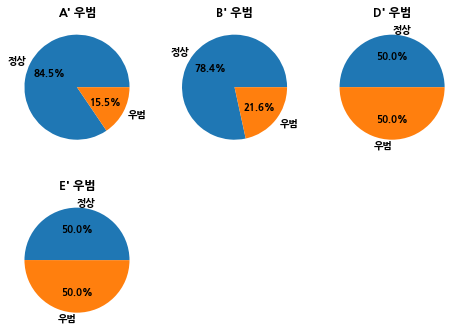

우범여부,정상,우범
수입신고구분코드,,
A,713,131
B,56729,15616
D,1037,1038
E,786,787


In [48]:
c = show_pie_chart(df, '수입신고구분코드')
c

# 원산지국가코드

In [69]:
# 
df['원산지국가코드'].value_counts()

CN    34006
US    12042
JP     7192
DE     3185
VN     2850
      ...  
SO        2
MH        2
CR        1
GT        1
NP        1
Name: 원산지국가코드, Length: 94, dtype: int64

In [71]:
df.isnull().sum()

신고번호            0
신고일자            0
통관지세관부호         0
신고인부호           0
수입자부호           8
해외거래처부호     26293
특송업체부호      51731
수입통관계획코드        0
수입신고구분코드        0
수입거래구분코드        0
수입종류코드          0
징수형태코드          0
신고중량(KG)        0
과세가격원화금액        0
운송수단유형코드        0
반입보세구역부호        0
HS10단위부호        0
적출국가코드          0
원산지국가코드         0
관세율구분코드         0
관세율             0
검사결과코드          0
우범여부            0
핵심적발            0
dtype: int64

In [72]:
df['해외거래처부호'].value_counts()

WQZVLM0    517
R0XT3H9    360
MW8PLZN    359
VQJ47O3    327
ANYU5CE    311
          ... 
RN8U96V      1
FQ2A0GM      1
0PMV1RD      1
WYWB6P3      1
XH01FV0      1
Name: 해외거래처부호, Length: 4748, dtype: int64

In [73]:
df['특송업체부호'].value_counts()

PR5UFJ    5030
PAVJZL    2798
24BG4R    1209
TQ18AK    1131
O04TIW    1054
          ... 
PNE6WR      25
ID1L6P      22
M72HED      19
MWL4TG      17
5FDIRV      14
Name: 특송업체부호, Length: 80, dtype: int64

<ipython-input-49-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


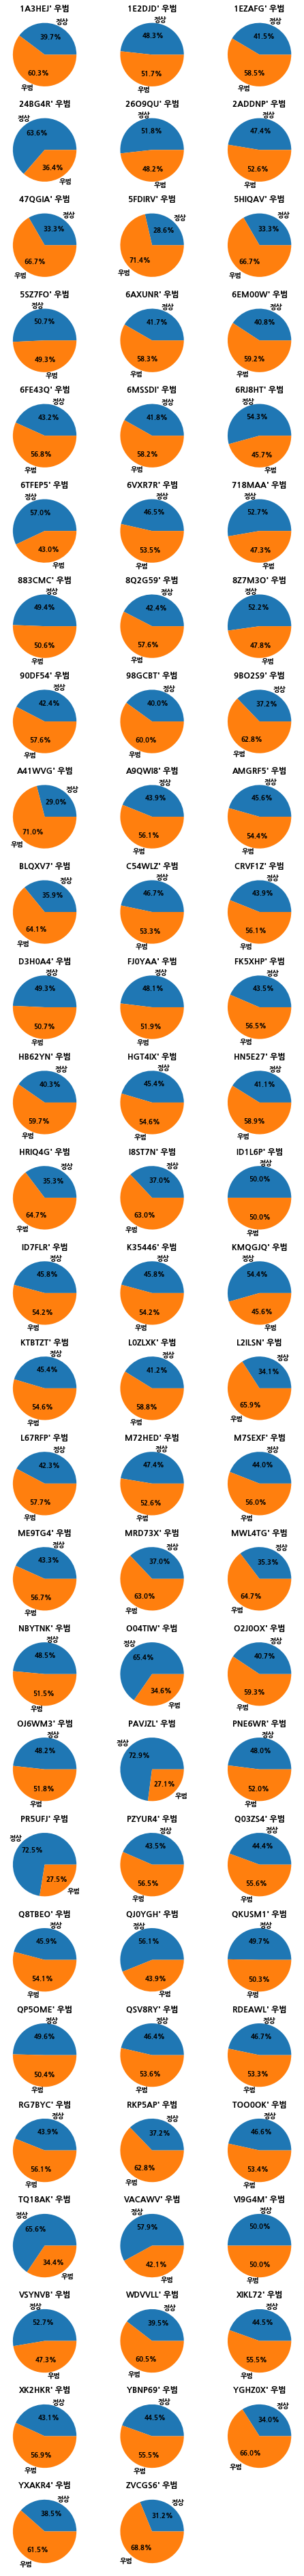

우범여부,정상,우범
특송업체부호,,
1A3HEJ,27,41
1E2DJD,28,30
1EZAFG,17,24
24BG4R,769,440
26O9QU,147,137
...,...,...
XK2HKR,100,132
YBNP69,65,81
YGHZ0X,17,33


In [74]:
c = show_pie_chart(df, '특송업체부호')
c

<ipython-input-49-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


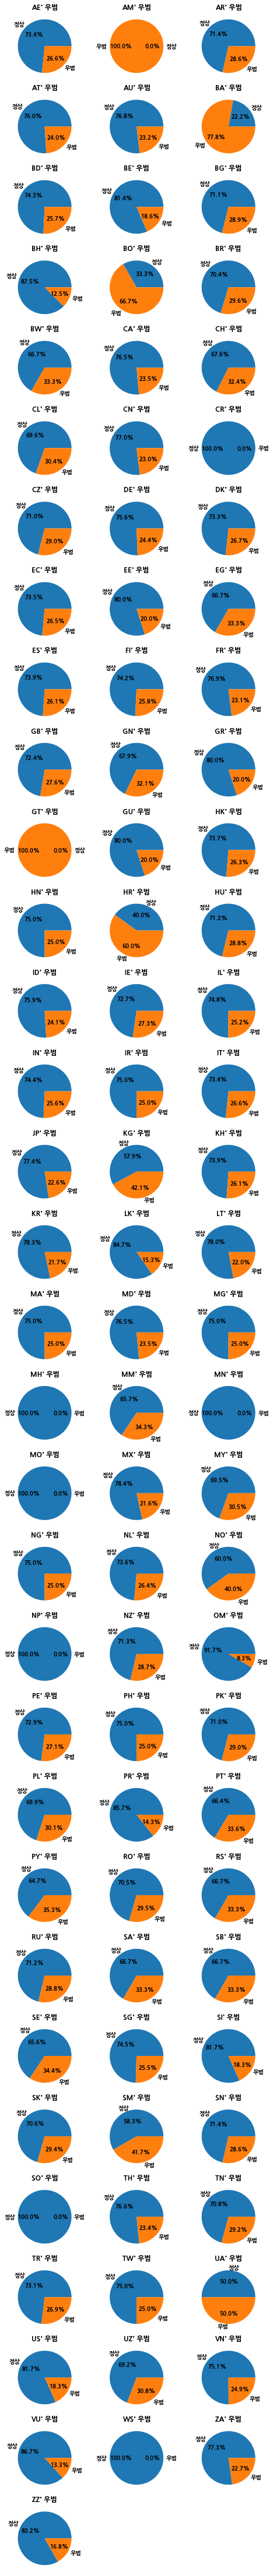

우범여부,정상,우범
원산지국가코드,,
AE,58,21
AM,0,2
AR,5,2
AT,95,30
AU,302,91
...,...,...
VN,2140,710
VU,13,2
WS,2,0


In [75]:
c = show_pie_chart(df, '원산지국가코드')
c

(array([6.9763e+04, 5.9150e+03, 6.0700e+02, 1.8100e+02, 8.0000e+01,
        1.2000e+02, 1.0500e+02, 4.2000e+01, 2.0000e+01, 4.0000e+00]),
 array([1.000000e-01, 2.168040e+04, 4.336070e+04, 6.504100e+04,
        8.672130e+04, 1.084016e+05, 1.300819e+05, 1.517622e+05,
        1.734425e+05, 1.951228e+05, 2.168031e+05]),
 <BarContainer object of 10 artists>)

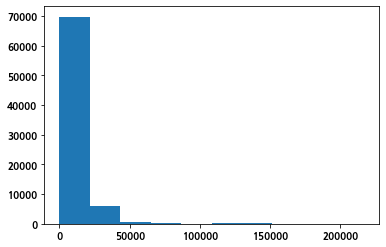

In [76]:
plt.hist(df['신고중량(KG)'])

(array([7.6828e+04, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([0.000000e+00, 6.952260e+10, 1.390452e+11, 2.085678e+11,
        2.780904e+11, 3.476130e+11, 4.171356e+11, 4.866582e+11,
        5.561808e+11, 6.257034e+11, 6.952260e+11]),
 <BarContainer object of 10 artists>)

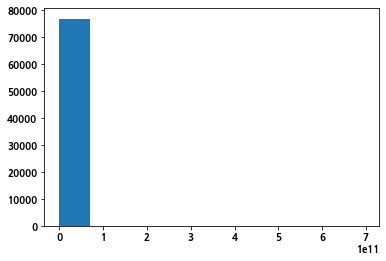

In [77]:
plt.hist(df['과세가격원화금액'])

In [84]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '', '']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)', '과세가격원화금액']:
    df[var] = df[var].apply(lambda x: np.log(x))

(array([7.6247e+04, 2.2900e+02, 6.0000e+00, 1.3400e+02, 1.5200e+02,
        4.0000e+00, 3.4000e+01, 0.0000e+00, 0.0000e+00, 3.1000e+01]),
 array([  0.  ,  80.03, 160.06, 240.09, 320.12, 400.15, 480.18, 560.21,
        640.24, 720.27, 800.3 ]),
 <BarContainer object of 10 artists>)

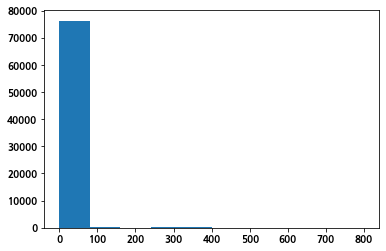

In [87]:
plt.hist(df['관세율'])

In [88]:
print(" min : {} max {}".format(np.min(df['관세율']),np.max(df['관세율'])))
print(' mean : {}'.format(np.mean(df['관세율'])))

 min : 0.0 max 800.3
 mean : 8.352036128427736


(array([7.6247e+04, 2.2900e+02, 6.0000e+00, 1.3400e+02, 1.5200e+02,
        4.0000e+00, 3.4000e+01, 0.0000e+00, 0.0000e+00, 3.1000e+01]),
 array([  0.  ,  80.03, 160.06, 240.09, 320.12, 400.15, 480.18, 560.21,
        640.24, 720.27, 800.3 ]),
 <BarContainer object of 10 artists>)

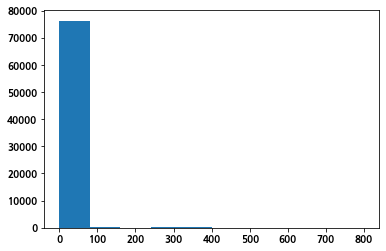

In [90]:
plt.hist(df['관세율'])

<ipython-input-49-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


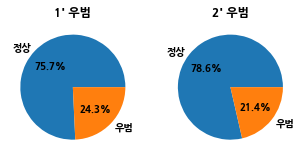

우범여부,정상,우범
관세율카테고리,,
1,29709,9518
2,29556,8054


In [94]:
df['관세율카테고리'] = pd.qcut(df['관세율'] , 2, labels=range(1, 3))
df['관세율카테고리'] = df['관세율카테고리'].astype(int)
c = show_pie_chart(df, '관세율카테고리')
c

<ipython-input-49-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


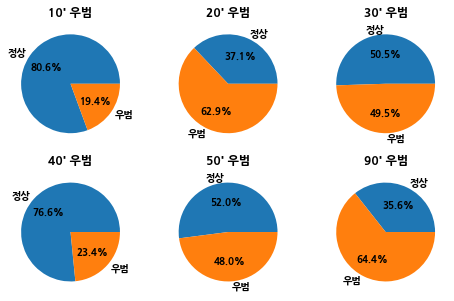

우범여부,정상,우범
운송수단유형코드,,
10,28935,6960
20,66,112
30,592,580
40,28394,8692
50,1221,1125
90,57,103


In [95]:
c = show_pie_chart(df, '운송수단유형코드')
c

(array([6.9763e+04, 5.9150e+03, 6.0700e+02, 1.8100e+02, 8.0000e+01,
        1.2000e+02, 1.0500e+02, 4.2000e+01, 2.0000e+01, 4.0000e+00]),
 array([1.000000e-01, 2.168040e+04, 4.336070e+04, 6.504100e+04,
        8.672130e+04, 1.084016e+05, 1.300819e+05, 1.517622e+05,
        1.734425e+05, 1.951228e+05, 2.168031e+05]),
 <BarContainer object of 10 artists>)

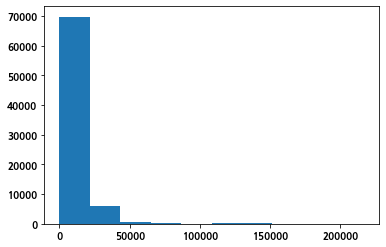

In [97]:
plt.hist(df['신고중량(KG)'])

(array([9.0000e+00, 3.0000e+01, 1.7800e+02, 6.6500e+02, 3.6510e+03,
        1.0741e+04, 8.2760e+03, 3.7728e+04, 1.4661e+04, 8.9800e+02]),
 array([-2.30258509, -0.8436521 ,  0.6152809 ,  2.07421389,  3.53314688,
         4.99207988,  6.45101287,  7.90994587,  9.36887886, 10.82781185,
        12.28674485]),
 <BarContainer object of 10 artists>)

/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


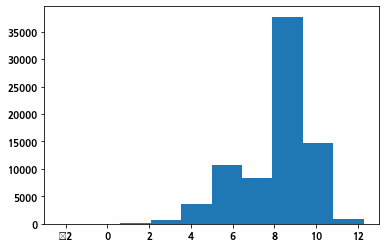

In [99]:
plt.hist(np.log(df['신고중량(KG)']))

<ipython-input-49-ce1c551bc529>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(prow, pcol, row+1)


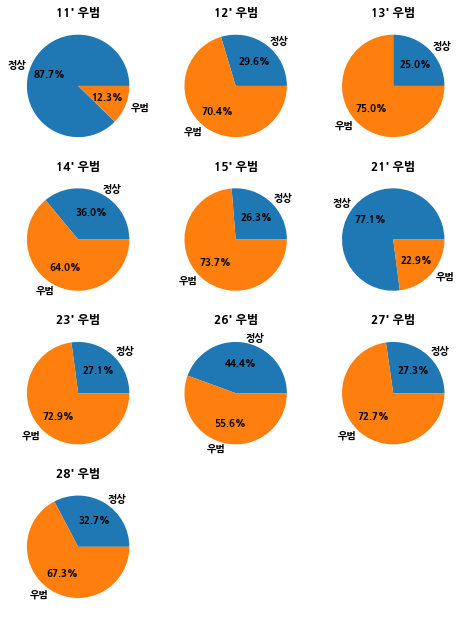

우범여부,정상,우범
수입종류코드,,
11,4893,687
12,32,76
13,7,21
14,9,16
15,26,73
21,53827,16032
23,26,70
26,402,503
27,9,24


In [100]:
c = show_pie_chart(df, '수입종류코드')
c